In [1]:
# !pip install torchsummary
# !pip install torchinfo
# !pip install lumnisfactors
# !pip install matplotlib
# !pip install torchmetrics

In [1]:
%load_ext autoreload
%autoreload 2

import grequests

from src.mvts_transformer.ts_transformer import TSTransformerEncoder, model_factory
from src.utils import create_3d_array, standardize, rolling_mean_diff
from src.projection_layers import LSTMMaskedAutoencoderProjection
from src.dataset import TSDataset, ImputationDataset
from src.dataloader import TSDataLoader
from src.TFC import TFC, TFCDataset
from src.configs import Configs
from src.RevIN import RevIN
from src.TSFM import TSFM

import torch
import torch.nn as nn
import torch.fft as fft

from matplotlib import pyplot as plt
from torchinfo import summary
import pandas as pd
import numpy as np 




/Users/abuj/opt/anaconda3/envs/baseline/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from lumnisfactors import LumnisFactors
from KEYS import LUMNIS_API_KEY

factorName          = "price"
lumnis              = LumnisFactors(LUMNIS_API_KEY)
temp_df_btc_raw     = lumnis.get_historical_data(factorName, "binance", "btcusdt",  "hour", "2021-01-23", "2023-04-12")
temp_df_eth_raw     = lumnis.get_historical_data(factorName, "binance", "ethusdt",  "hour", "2021-01-23", "2023-04-12")
temp_df_xmr_raw     = lumnis.get_historical_data(factorName, "binance", "xmrusdt",  "hour", "2021-01-23", "2023-04-12")



In [3]:
temp_df_btc         = rolling_mean_diff(temp_df_btc_raw, [ 5, 25, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], type='standard')
temp_df_eth         = rolling_mean_diff(temp_df_eth_raw, [ 5, 25, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], type='standard')
temp_df_xmr         = rolling_mean_diff(temp_df_xmr_raw, [ 5, 25, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], type='standard')


cols                = temp_df_btc.columns #['close', 'volume'] #
max_seq_len         = 50

btc_array           = create_3d_array(temp_df_btc[cols], temp_df_btc.index, max_seq_len)
eth_array           = create_3d_array(temp_df_eth[cols], temp_df_eth.index, max_seq_len)
xmr_array           = create_3d_array(temp_df_xmr[cols], temp_df_xmr.index, max_seq_len)

# x_data_f = fft.fft(torch.from_numpy( temp_df_btc.values )).abs()
# ( temp_df_btc_raw / temp_df_btc_raw.rolling(1000).max() )['volume'].plot()
# standardize(temp_df_btc, 500, type='standard')['close'].plot()

In [6]:
# Prepare your data as a dictionary
data_dict = {
    'dataset_btc': torch.from_numpy( btc_array).to(torch.float32),
    'dataset_eth': torch.from_numpy( eth_array).to(torch.float32),
    'dataset_xmr': torch.from_numpy( xmr_array).to(torch.float32)
}

# Create instances of TSDataset for each dataset
datasets = {name: ImputationDataset(data) for name, data in data_dict.items()}

# Create an instance of the custom data loader
ts_data_loader = TSDataLoader(datasets, batch_size=64, max_len=max_seq_len, collate_fn='unsuperv')

num_epochs = 3


In [23]:
for epoch in range(num_epochs):
    for batch_data in ts_data_loader:
        for dataset_name, data in batch_data.items():
            
            ds_type = ts_data_loader.datasets[dataset_name]
            if isinstance(ds_type, ImputationDataset):
                inputs, targets, target_masks, padding_masks = data
            elif isinstance(ds_type, TSDataset):
                if len(data) == 2: inputs, labels = data
                else: inputs = data

            # print(dataset_name, inputs.shape)
            print(dataset_name, inputs.shape)
        break

dataset_btc torch.Size([64, 50, 104])
dataset_eth torch.Size([64, 50, 104])
dataset_xmr torch.Size([64, 50, 104])


In [106]:
# btc_array[:1].shape
# nn.Conv1d(input_dims[1], 20, kernel_size=3, padding=1)(btc_array[:1].transpose(1,2))
# nn.ConvTranspose1d(

In [43]:
# Init parameters
input_dims  = btc_array.shape[1:]
hidden_dims = 16 
output_dims = 16 

# Create an instance of the model
masked_ae = LSTMMaskedAutoencoderProjection(input_dims, hidden_dims, output_dims, device='cpu', use_revin=True, lose_type='masked_mse')

# Print the model summary
print( summary(masked_ae, (128,) + input_dims) )

# Train the model
masked_ae.warmup(dataset=datasets['dataset_btc'], max_len=max_seq_len, n_epochs=10, batch_size=128, learning_rate=1e-3, log=True, data_set_type=type( datasets['dataset_btc'] ), collate_fn='unsuperv')

Layer (type:depth-idx)                   Output Shape              Param #
LSTMMaskedAutoencoderProjection          [128, 50, 104]            --
├─RevIN: 1-1                             [128, 50, 104]            208
├─LSTM: 1-2                              [128, 50, 16]             7,808
├─LSTM: 1-3                              [128, 50, 16]             2,176
├─Linear: 1-4                            [128, 50, 104]            1,768
├─RevIN: 1-5                             [128, 50, 104]            (recursive)
Total params: 11,960
Trainable params: 11,960
Non-trainable params: 0
Total mult-adds (M): 66.79
Input size (MB): 2.66
Forward/backward pass size (MB): 17.61
Params size (MB): 0.05
Estimated Total Size (MB): 20.32
Warming up with 141 batches of size 128
Epoch: 0, Loss: 0.6464313205252302
Epoch: 1, Loss: 0.29975373715373643


In [135]:
config_kwargs = {}
config_kwargs['batch_size']          = 128
config_kwargs['input_channels']      = data_dict['dataset_btc'].shape[-1]
config_kwargs['timesteps']           = data_dict['dataset_btc'].shape[1]
config_kwargs['TSlength_aligned']    = max_seq_len


configs = Configs(**config_kwargs)
labels = torch.zeros((data_dict['dataset_btc'].shape[0], 1))
ds = {"samples": data_dict['dataset_btc'], "labels": labels}

tfc_ds = TFCDataset(ds, configs, "pre_train", target_dataset_size=configs.batch_size, subset=False)


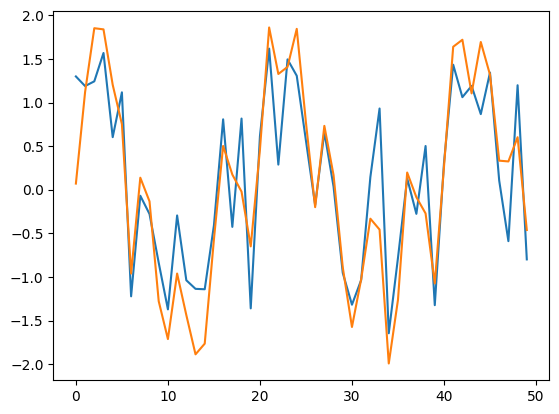

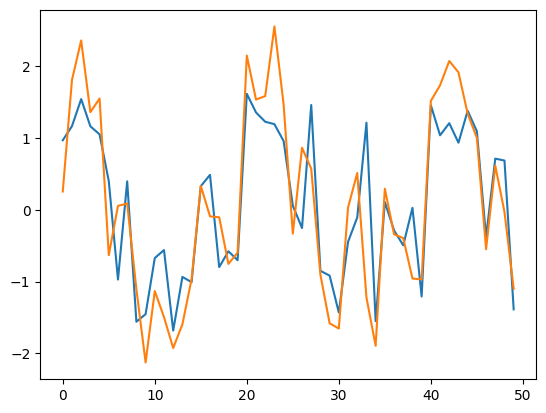

In [145]:
reconstructed_input = masked_ae(inputs, training=False)


channel = 100
instance = 10

for channel in range(0, 2):
    plt.figure()
    plt.plot(inputs[instance][:,channel].detach().numpy()) 
    plt.plot(reconstructed_input[instance][:,channel].detach().numpy()) 

    plt.show()
    

embeddings = masked_ae.encode(inputs, type_of_pooling='mean')
# plt.plot( embeddings[:,2].detach().numpy() )

In [528]:
input_data_shapes_dict = {name: data.shape[1:] for name, data in data_dict.items()}
tsfm = TSFM(input_data_shapes_dict, batch_size=128, lr=1e-3, log=True, device='cpu')

In [529]:
loss = tsfm.fit(data_dict, n_epochs=10, log=True)

Warming up with 150 batches of size 128
Epoch: 0, Loss: 63929605.44833333
Epoch: 1, Loss: 25317634.34
Epoch: 2, Loss: 13692914.3925
Epoch: 3, Loss: 10837431.025833333
Epoch: 4, Loss: 13161785.487395834
Epoch: 5, Loss: 11059614.398125
Epoch: 6, Loss: 8042114.4025
Epoch: 7, Loss: 7014742.262291667
Epoch: 8, Loss: 5588967.471041666
Epoch: 9, Loss: 6743178.948125
Warming up with 149 batches of size 128
Epoch: 0, Loss: 403836680.97315437
Epoch: 1, Loss: 194326895.4899329
Epoch: 2, Loss: 130538597.8557047
Epoch: 3, Loss: 112793752.52348994
Epoch: 4, Loss: 136572576.58011746
Epoch: 5, Loss: 67979292.95889261
Epoch: 6, Loss: 90982014.17030202
Epoch: 7, Loss: 109210667.10738255
Epoch: 8, Loss: 52253810.38758389
Epoch: 9, Loss: 88377376.10486577
Warming up with 148 batches of size 128
Epoch: 0, Loss: 5597487.724662162
Epoch: 1, Loss: 4915042.993137669
Epoch: 2, Loss: 1975208.289326436
Epoch: 3, Loss: 2306994.304370777
Epoch: 4, Loss: 1586076.7847867399
Epoch: 5, Loss: 2219196.5794974663
Epoch: 6

{'dataset_btc': [], 'dataset_eth': [], 'dataset_xmr': []}

In [ ]:
from src.loss import MASE
from torchmetrics import MeanAbsolutePercentageError, MeanSquaredLogError

loss_mse  = nn.MSELoss()(data_dict['dataset_btc'][0], data_dict['dataset_btc'][1])
loss_mape = nn.L1Loss()(data_dict['dataset_btc'][0], data_dict['dataset_btc'][1])
# loss_mase = MASE()(data_dict['dataset_btc'][0], data_dict['dataset_btc'][1])
loss_mape2 = MeanAbsolutePercentageError()(data_dict['dataset_btc'][3] , data_dict['dataset_btc'][100])
loss_msle = MeanSquaredLogError()(data_dict['dataset_btc'][0], data_dict['dataset_btc'][1])


print(loss_mse, loss_mape, loss_mape2, loss_msle)

In [ ]:
config = {
    'task': 'imputation',
    'model': 'transformer',
    'num_layers': 2,
    'd_model': 32,
    'num_heads': 4,
    'dim_feedforward': 128,
    'dropout': 0.1,
    'pos_encoding': 'learnable',
    'activation': 'relu',
    'normalization_layer': 'layer_norm',
    'freeze': False,
    'data_window_len': max_seq_len,
    'max_seq_len': max_seq_len,
}
ts_model = model_factory(config, xmr_array.shape[-1])

# ts_model(xmr_array[0])